In [128]:
import time

import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
import sklearn.datasets as ds
from sklearn.model_selection import train_test_split
from sklearn import neighbors, svm, tree, linear_model, ensemble, neural_network, metrics
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import cross_val_score
from sklearn.grid_search import GridSearchCV

In [2]:
%matplotlib inline
plt.style.use('bmh')

In [3]:
pd.set_option("max_columns",90, "max_rows", 90)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### Data Preprocessing

In [4]:
raw_df = pd.read_csv('Gse_panel_current_sample_raw.csv')
raw_df.head()

,loan_id,orig_chn,orig_rt,orig_upb,oltv,num_bo,dti,loan_purp,prop_type,num_unit,occ_stat,prop_state,msa,fico,oyr,oqtr,ind_ede,pmms_o,avg_upb,OUPB_Rel,fhb_flag,loan_age_qtr,year,qtr,status,status_prev,PMMS,HPI_O,HPI,ur,CUPB_calc,Orig_value,CLTV
0,F100Q1057907,T,8.00,65000,41,2.0,24,P,SF,1.0,O,WI,33340.0,752,2000,1,0.006619,8.26,124597.46950,0.521680,N,2,2000,3,Current,Current,8.03,156.42,161.16,4.000000,64866.87370,158536.58540,39.712615
1,F100Q1045595,T,8.25,81000,67,1.0,31,P,CO,1.0,O,IL,16974.0,787,2000,1,0.006619,8.26,144321.44180,0.561247,N,5,2001,2,Current,Current,7.13,140.68,156.12,4.400000,80348.95986,120895.52240,59.893918
2,8.32073E+11,C,8.25,148000,80,2.0,51,P,SF,1.0,P,WI,33340.0,733,2000,1,0.006619,8.26,124597.46950,1.187825,N,4,2001,1,Current,Current,7.01,156.42,166.05,4.230000,147117.00180,185000.00000,74.864766
3,F100Q1132127,R,8.75,94000,63,2.0,24,N,SF,1.0,O,MI,NaN,781,2000,1,0.006619,8.26,121230.93190,0.775380,N,2,2000,3,Current,Current,8.03,166.37,171.77,4.000000,93834.43235,149206.34920,60.911968
4,F100Q1027118,R,8.00,60000,61,2.0,28,P,SF,1.0,O,OH,45780.0,782,2000,1,0.006619,8.26,99538.46154,0.602782,N,10,2002,3,Current,Current,6.29,144.24,157.62,6.555973,58801.29455,98360.65574,54.066644


In [5]:
# log transformation[hold on]

In [73]:
# drop the useless columns and rows - handle the missing data[hold on]
df = raw_df.dropna(how='any').copy()
df['status'] = df['status'].apply(lambda x: int(x=='D60-D90'))
X = df.drop(['loan_id', 'status', 'status_prev', 'prop_state'], axis=1).copy()
y = df['status'].copy()

# split the sample
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# convert the categorical vars to binary vars
X_train = pd.get_dummies(X_train)

### logistic regression

In [74]:
# logistic regression
linear_lr = linear_model.LogisticRegression()
linear_lr.fit(X_train, y_train)
X_test = pd.get_dummies(X_test)
y_pred = linear_lr.predict(X_test)
print(f"Accuracy = {100*np.sum(y_pred == y_test)/len(y_test)}%")

Accuracy = 99.8021125677088%


In [75]:
confusion_matrix(y_test, y_pred)

array([[188118,      0],
       [   373,      0]], dtype=int64)

In [76]:
print(y_train.value_counts(normalize=True)*100)

0    99.778238
1     0.221762
Name: status, dtype: float64


0.814902984143174


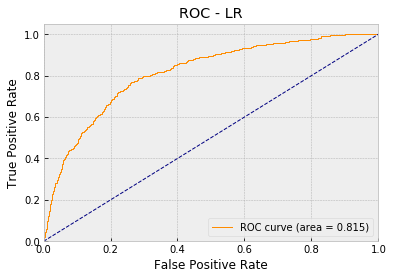

In [77]:
# ROC and AUC  
conf_score = linear_lr.decision_function(X_test)
print(roc_auc_score(y_test, conf_score))    
fpr, tpr, _ = roc_curve(y_test, conf_score)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - LR')
plt.legend(loc="lower right")
plt.show()

### AdaBoost

In [78]:
bdt = AdaBoostClassifier(linear_model.LogisticRegression(), algorithm="SAMME", n_estimators=50,learning_rate=0.5)
bdt.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          learning_rate=0.5, n_estimators=50, random_state=None)

In [79]:
y_pred = bdt.predict(X_test)

In [80]:
confusion_matrix(y_test, y_pred)

array([[187876,    242],
       [   370,      3]], dtype=int64)

0.7868355658462842


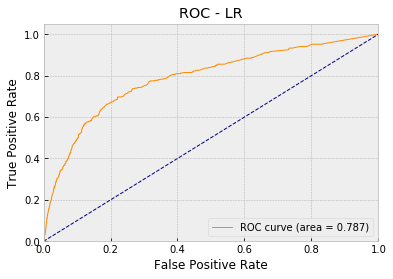

In [81]:
# ROC and AUC  
conf_score = bdt.decision_function(X_test)
print(roc_auc_score(y_test, conf_score))    
fpr, tpr, _ = roc_curve(y_test, conf_score)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - LR')
plt.legend(loc="lower right")
plt.show()

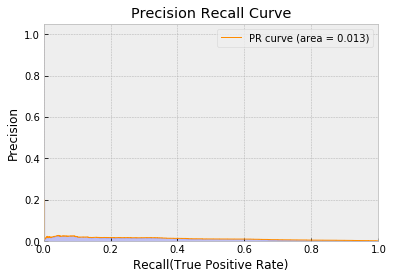

In [129]:
precision, recall, _ = precision_recall_curve(y_test, conf_score)

plt.figure()
plt.plot(recall, precision, color='darkorange', lw=1, label='PR curve (area = %0.3f)' % average_precision_score(y_test, conf_score))
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall(True Positive Rate)')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')
plt.legend(loc="upper right")
plt.show()

### Gradient Boosting


In [85]:
clf = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=100, 
                                 subsample=0.6, min_samples_split=50, min_samples_leaf=50,
                                 max_depth=2, random_state=0, verbose=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [86]:
confusion_matrix(y_test, y_pred)

array([[188118,      0],
       [   373,      0]], dtype=int64)

0.8501942423509379


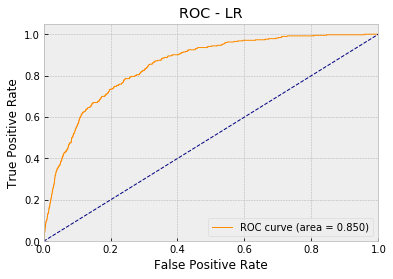

In [87]:
# ROC and AUC  
conf_score = clf.decision_function(X_test)
print(roc_auc_score(y_test, conf_score))    
fpr, tpr, _ = roc_curve(y_test, conf_score)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - LR')
plt.legend(loc="lower right")
plt.show()

### xgboost  

### Hyperparams Tuning Test - GBT

In [103]:
# model fit function
def modelfit(clf, x_train, y_train, perform_cv=True, display_fi=True, cv_folds=5):
    clf.fit(x_train, y_train)
    y_train_pred = clf.predict(x_train)
    y_train_predprob = clf.predict_proba(x_train)[:, 1]
    
    if perform_cv:
        cv_score = cross_val_score(clf, x_train, y_train, cv=cv_folds, scoring='roc_auc')
    
    print('\nModel Report: ')
    print("Accuracy : %.4g" % metrics.accuracy_score(y_train.values, y_train_pred))
    print(f"AUC Score (Train): {metrics.roc_auc_score(y_train, y_train_predprob)}")
          
    if perform_cv:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
    
    if display_fi:
        feat_imp = pd.Series(clf.feature_importances_, list(X_train.columns)).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

#### Baseline Case


Model Report: 
Accuracy : 0.9979
AUC Score (Train): 0.8780250216672338
CV Score : Mean - 0.8565885 | Std - 0.007029166 | Min - 0.8443983 | Max - 0.8663697


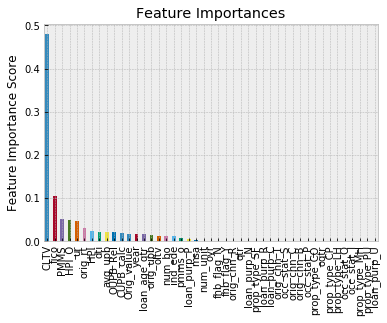

In [104]:
# using default params of GB classifier
gbm0 = GradientBoostingClassifier(random_state=10)
modelfit(gbm0, X_train, y_train)

#### Tuning the number of trees, learning rate = 0.1

In [109]:
param_test1 = {'n_estimators': list(range(20, 81, 10))}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=500, min_samples_leaf=50, 
                                                               max_depth=8, max_features='sqrt', subsample=0.8, random_state=10), 
                        param_grid = param_test1, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gsearch1.fit(X_train, y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.84559, std: 0.00920, params: {'n_estimators': 20},
  mean: 0.84992, std: 0.00859, params: {'n_estimators': 30},
  mean: 0.85035, std: 0.00909, params: {'n_estimators': 40},
  mean: 0.84988, std: 0.00942, params: {'n_estimators': 50},
  mean: 0.84972, std: 0.00970, params: {'n_estimators': 60},
  mean: 0.84841, std: 0.01031, params: {'n_estimators': 70},
  mean: 0.84776, std: 0.01014, params: {'n_estimators': 80}],
 {'n_estimators': 40},
 0.8503475557221745)

#### Tuning max_depth and num_samples_split

In [111]:
start = time.time()
param_test2 = {'max_depth': list(range(5, 16, 2)), 'min_samples_split': list(range(200, 1001, 200))}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60, max_features='sqrt', subsample=0.8, random_state=10), 
                        param_grid = param_test2, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gsearch2.fit(X_train, y_train)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_
end = time.time()
print(f'gsearch2: {start-end} seconds')

gsearch2: {start-end} seconds


In [119]:
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.85363, std: 0.00747, params: {'max_depth': 5, 'min_samples_split': 200},
  mean: 0.85260, std: 0.00632, params: {'max_depth': 5, 'min_samples_split': 400},
  mean: 0.85144, std: 0.00650, params: {'max_depth': 5, 'min_samples_split': 600},
  mean: 0.85413, std: 0.00509, params: {'max_depth': 5, 'min_samples_split': 800},
  mean: 0.85270, std: 0.00304, params: {'max_depth': 5, 'min_samples_split': 1000},
  mean: 0.84786, std: 0.00652, params: {'max_depth': 7, 'min_samples_split': 200},
  mean: 0.85093, std: 0.00721, params: {'max_depth': 7, 'min_samples_split': 400},
  mean: 0.85184, std: 0.01074, params: {'max_depth': 7, 'min_samples_split': 600},
  mean: 0.85145, std: 0.00569, params: {'max_depth': 7, 'min_samples_split': 800},
  mean: 0.85027, std: 0.00625, params: {'max_depth': 7, 'min_samples_split': 1000},
  mean: 0.83608, std: 0.00963, params: {'max_depth': 9, 'min_samples_split': 200},
  mean: 0.84191, std: 0.01068, params: {'max_depth': 9, 'min_samples_split': 400},
  

#### Tuning min_samples_leaf

In [112]:
start = time.time()
param_test3 = {'min_samples_split': list(range(1000, 2100, 200)), 'min_samples_leaf': list(range(30, 71, 10))}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60, max_depth=9, max_features='sqrt', subsample=0.8, random_state=10), 
                        param_grid = param_test3, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gsearch3.fit(X_train, y_train)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_
end = time.time()
print(f'\ngsearch3: {start-end} seconds')


gsearch3: {start-end} seconds


In [120]:
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.84483, std: 0.00833, params: {'min_samples_leaf': 30, 'min_samples_split': 1000},
  mean: 0.84890, std: 0.00827, params: {'min_samples_leaf': 30, 'min_samples_split': 1200},
  mean: 0.84758, std: 0.01227, params: {'min_samples_leaf': 30, 'min_samples_split': 1400},
  mean: 0.84794, std: 0.00885, params: {'min_samples_leaf': 30, 'min_samples_split': 1600},
  mean: 0.84977, std: 0.00841, params: {'min_samples_leaf': 30, 'min_samples_split': 1800},
  mean: 0.85153, std: 0.01009, params: {'min_samples_leaf': 30, 'min_samples_split': 2000},
  mean: 0.85135, std: 0.00864, params: {'min_samples_leaf': 40, 'min_samples_split': 1000},
  mean: 0.84738, std: 0.01087, params: {'min_samples_leaf': 40, 'min_samples_split': 1200},
  mean: 0.84620, std: 0.01225, params: {'min_samples_leaf': 40, 'min_samples_split': 1400},
  mean: 0.85100, std: 0.01039, params: {'min_samples_leaf': 40, 'min_samples_split': 1600},
  mean: 0.84972, std: 0.00924, params: {'min_samples_leaf': 40, 'min_samples_spl


Model Report: 
Accuracy : 0.9978
AUC Score (Train): 0.9484962328670675
CV Score : Mean - 0.8531821 | Std - 0.01094144 | Min - 0.8421924 | Max - 0.873064


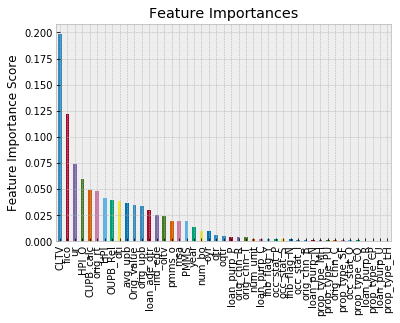

In [113]:
modelfit(gsearch3.best_estimator_, X_train, y_train)

In [114]:
#### Tuning max_features

In [115]:
start = time.time()
param_test4 = {'max_features': list(range(7,20,2))}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60, max_depth=9, min_samples_split=1200, 
                                                               min_samples_leaf=60, subsample=0.8, random_state=10),
                        param_grid = param_test4, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gsearch4.fit(X_train, y_train)
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_
end = time.time()
print(f'\ngsearch4: {start-end} seconds')


gsearch4: {start-end} seconds


In [121]:
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.84698, std: 0.00995, params: {'max_features': 7},
  mean: 0.84897, std: 0.00948, params: {'max_features': 9},
  mean: 0.85039, std: 0.00815, params: {'max_features': 11},
  mean: 0.84806, std: 0.00630, params: {'max_features': 13},
  mean: 0.85132, std: 0.00808, params: {'max_features': 15},
  mean: 0.84931, std: 0.00969, params: {'max_features': 17},
  mean: 0.85143, std: 0.01102, params: {'max_features': 19}],
 {'max_features': 19},
 0.8514272896987214)


Model Report: 
Accuracy : 0.9978
AUC Score (Train): 0.9368786992093632
CV Score : Mean - 0.8514273 | Std - 0.01102089 | Min - 0.8361489 | Max - 0.8697231


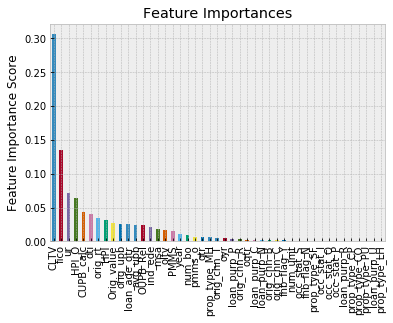

In [124]:
modelfit(gsearch4.best_estimator_, X_train, y_train)

In [116]:
#### Tuning subsample

In [117]:
start = time.time()
param_test5 = {'subsample': [0.5,0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60, max_depth=9, min_samples_split=1200,
                                                               min_samples_leaf=60, subsample=0.8, random_state=10, max_features=7),
                        param_grid = param_test5, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gsearch5.fit(X_train, y_train)
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_
end = time.time()
print(f'\ngsearch5: {start-end} seconds')


gsearch5: {start-end} seconds


In [122]:
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

([mean: 0.84627, std: 0.00927, params: {'subsample': 0.5},
  mean: 0.84261, std: 0.00930, params: {'subsample': 0.6},
  mean: 0.84846, std: 0.00927, params: {'subsample': 0.7},
  mean: 0.84962, std: 0.00823, params: {'subsample': 0.75},
  mean: 0.84698, std: 0.00995, params: {'subsample': 0.8},
  mean: 0.84936, std: 0.00832, params: {'subsample': 0.85},
  mean: 0.84926, std: 0.00691, params: {'subsample': 0.9}],
 {'subsample': 0.75},
 0.849617186365548)

In [118]:
#### Tuning the combination of learning rate and the num of trees

In [123]:
print(f'\ngsearch5: {start-end} seconds')


gsearch5: -3269.607521533966 seconds
